# MLP Neural Net Notebook
This python notebook is used to demonstrate a Multi-Layer  perceptron neural Net architecture
for regression and classification tasks of the [Wine Qaulity dataset](https://archive.ics.uci.edu/dataset/186/wine+quality)

A replica of this functionality is also ported to C# .Net 

### Imports

In [144]:
import pandas as pd
import numpy as np
import math
from pprint import pprint
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.utils.vis_utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from typing import Dict, Tuple, List, Any, Optional
import sys
import enum
from tqdm.notebook import trange, tqdm
from tqdm.notebook import tqdm_notebook
from collections import namedtuple
%matplotlib inline

### Global constants

In [168]:
#DATA_FILE_PATH = "../data/winequality-red.csv"
DATA_FILE_PATH = "../data/uci_auto_mpg_dataset.csv" 
performance_plot_details = namedtuple(
    "performance_plot_details",["problem_title", "feature_dim_index", "feature_dim_name", "response" ]
)
PERFORMANCE_PLOT_DETAILS = performance_plot_details("UCI Auto MPG prediction", 1, "Horsepower", "MPG")

FILE_DELIMITER = ";"
TRAIN_VALID_SPLIT_FRACTION = 0.80
VALID_SPLIT_FRACTION = 0.20
TEST_SPLIT_FRACTION = 1.0 - TRAIN_VALID_SPLIT_FRACTION
IS_SHUFFLE_DATA = True
NEURAL_NET_TOPOLOGY_FILENAME = "../resources/regression_neural_net.png"

### Enumerations
 - Task type enums

In [132]:
class TaskType(enum.Enum):
    regression = 1
    classification = 2

### Get the ML task dataset
 - Read the dataset from the store (csv file)
 - Extract feature dataset (X) and response/labels (y)

In [133]:
data_df = pd.read_csv(DATA_FILE_PATH, sep=FILE_DELIMITER)
X = data_df.values[:, :-1]
y = data_df.values[:, -1].reshape(-1,1)

In [134]:
data_df.head(5)

,Displacement,Horsepower,Weight,Acceleration,MPG
0,130.0,3504.0,12.0,70,1
1,165.0,3693.0,11.5,70,1
2,150.0,3436.0,11.0,70,1
3,150.0,3433.0,12.0,70,1
4,140.0,3449.0,10.5,70,1


In [135]:
X[:5]

array([[ 130. , 3504. ,   12. ,   70. ],
       [ 165. , 3693. ,   11.5,   70. ],
       [ 150. , 3436. ,   11. ,   70. ],
       [ 150. , 3433. ,   12. ,   70. ],
       [ 140. , 3449. ,   10.5,   70. ]])

In [136]:
y[:5]

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.]])

### Preprocess dataset
 - Split data into train, validation and test datasets
 - Apply Min-Max Scaling

In [176]:
def splitDataset(
    X: np.ndarray, 
    y: np.ndarray,    
    is_shuffle: bool = IS_SHUFFLE_DATA
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    X_copy = X.copy()
    y_copy = y.copy()
    n_all_rows = X.shape[0]
    n_train_valid_rows = int(TRAIN_VALID_SPLIT_FRACTION * n_all_rows)
        
    if is_shuffle:
        X_copy = np.random.permutation(X_copy)
        y_copy = np.random.permutation(y_copy)
        
    X_train_valid = X_copy[:n_train_valid_rows, :]
    X_test = X_copy[n_train_valid_rows:, :]
    
    y_train_valid = y_copy[:n_train_valid_rows, :]
    y_test = y_copy[n_train_valid_rows:, :]

    return (X_train_valid, X_test, y_train_valid, y_test)

def computeMinMaxScaling(
    dataset: np.ndarray, 
    min_max: Tuple[np.ndarray, np.ndarray] = None
) -> Tuple[np.ndarray, Tuple[np.ndarray, np.ndarray]]:
    def computeMinMax(dataset: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        min = np.min(dataset, axis=0)
        max = np.max(dataset, axis=0)
        return (min, max)

    if min_max is None:
        min_max = computeMinMax(dataset)
        
    min, max = min_max
    dataset_scaled = (dataset - min) / (max - min)
    return dataset_scaled, min_max

X_train_valid, X_test, y_train_valid, y_test = splitDataset(X, y)
print(f"X_train_valid:\n{X_train_valid[:5]}\nX_test:\n{X_test[:5]}\n")
print(f"y_train_valid:\n{y_train_valid[:5]}\ny_train_valid:\n{y_test[:5]}\n")


# X_train_scaled, X_min_max = computeMinMaxScaling(X_train)
# X_valid_scaled, _ = computeMinMaxScaling(X_valid, X_min_max)
# X_test_scaled, _ = computeMinMaxScaling(X_test, X_min_max)

# y_train_scaled, y_min_max = computeMinMaxScaling(y_train)
# y_valid_scaled, _ = computeMinMaxScaling(y_valid, y_min_max)
# y_test_scaled, _ = computeMinMaxScaling(y_test, y_min_max)



X_train_valid:
[[  84.  2370.    13.    82. ]
 [  72.  2565.    13.6   76. ]
 [  90.  3420.    22.2   79. ]
 [  91.  2582.    14.    73. ]
 [  95.  3785.    19.    75. ]]
X_test:
[[ 108.  2930.    15.5   76. ]
 [  81.  2220.    16.9   76. ]
 [ 100.  2914.    16.    75. ]
 [  80.  1915.    14.4   79. ]
 [ 105.  3613.    16.5   74. ]]

y_train_valid:
[[1.]
 [1.]
 [3.]
 [2.]
 [1.]]
y_train_valid:
[[1.]
 [1.]
 [3.]
 [3.]
 [3.]]



### MLP Neural Net
 - Class encpasulating the functionality of a MLP neural net

In [225]:
class MLPNeuralNet:
    def __init__(
        self,
        X: np.array,
        y: np.array,
        network_topology: Dict[str, Any],
        network_params: Dict[str, Any],
        task_type: TaskType = TaskType.regression
    ):
        """
        Constructor
        """
        print("Constructing the MLP neural network ..")
        self._X_train_valid, self._X_test, self._y_train_valid, self._y_test = splitDataset(X, y, is_shuffle=False)
        self._n_features = self._X_train_valid.shape[1]
        self._n_nodes_per_hidden_layer = network_topology["n_nodes_per_hidden_layer"]
        self._n_layers = len(self._n_nodes_per_hidden_layer)        
        self._optimizer_type = network_params["optimizer_type"]
        self._hidden_activation_function = network_params["hidden_activation_function"]
        self._batch_size = network_params["batch_size"]
        self._n_epochs = network_params["n_epochs"]
        self._validation_split = network_params["validation_split"]
        self._loss_function = network_params["loss_function"]
        self._performance_function = network_params["performance_metric"]
        self._task_type = task_type
        self._early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

        # self._X_train_valid_scaled, self._X_min_max = computeMinMaxScaling(self._X_train_valid)
        # self._X_test_scaled, _ = computeMinMaxScaling(self._X_test, self._X_min_max)        
        # self._y_train_valid_scaled, self._y_min_max = computeMinMaxScaling(self._y_train_valid)
        # self._y_test_scaled, _ = computeMinMaxScaling(self._y_test, self._y_min_max)
        self._normalizer = self.createNormalizer()
                
        self._model = None
        self._history = None
        self._train_accuracy = None
        self._valid_accuracy = None
        self._train_loss = None
        self._valid_loss = None
        

    def createNormalizer(self) -> Any:
        """
        Create the data normalizer
        """
        normalizer = tf.keras.layers.Normalization(input_dim=self._X_train_valid.shape[1], axis=-1)
        normalizer.adapt(np.array(self._X_train_valid))
        return normalizer
        

    def _createMultipleHiddenLayerNN(self):
        """
        Creates a multiple hidden layer NN topology
        """
        self._model = tf.keras.Sequential()
        self._model.add(self._normalizer)
        self._model.add(tf.keras.layers.Dense(
            units=self._n_nodes_per_hidden_layer[0],
            # input_shape=(self._n_features,), 
            activation=self._hidden_activation_function)
        )
        if len(self._n_nodes_per_hidden_layer) > 1:
            for n_hidden_nodes in self._n_nodes_per_hidden_layer[1:]:
                self._model.add(tf.keras.layers.Dense(n_hidden_nodes, activation=self._hidden_activation_function))
        self._model.add(tf.keras.layers.Dense(1,))
        self._model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
            loss ='mae', 
            metrics=[self.rSquared])
        return self._model

    def createNeuralNetModel(self):
        """
        Creates the Multi-Layer Perceptron Neural Net
        """
        print("Creating the neural network..")
        self._model = self._createMultipleHiddenLayerNN()
        self.visualizeNeuralNetwork()

    def rSquared(
        self, 
        y: Any, 
        y_hat: Any
    ) -> Any:
        """
        Method computes the coefficient of goodness (R^2) metric
        :param y: Actaul response
        :param y_hat: Predicted response
        :return: Returns the R^2 metric
        """
        #print(f"y: {tf.print(y)}\ty_hat: {tf.print(y_hat)}")
        residual = tf.reduce_sum(tf.square(tf.subtract(y, y_hat)))
        total = tf.reduce_sum(tf.square(tf.subtract(y, tf.reduce_mean(y))))
        r2 = tf.subtract(1.0, tf.divide(residual, total))
        return r2

    def trainRegressionModel(self):
        """
        Computes the training cycle for regression problem using a neural network model
        """
        self._history = self._model.fit(
            self._X_train_valid,
            self._y_train_valid,
            epochs=self._n_epochs, 
            # batch_size=self._batch_size,
            validation_split=self._validation_split,
            callbacks=[self._early_stop]
            )
        self._train_accuracy = self._model.history.history["rSquared"]
        self._valid_accuracy = self._model.history.history["val_rSquared"]
        self._train_loss = self._model.history.history["loss"]
        self._valid_loss = self._model.history.history["val_loss"]
        return {
            "rSquared": self._train_accuracy,
            "val_rSquared": self._valid_accuracy,
            "loss": self._train_loss,
            "val_loss": self._valid_loss
        }

    def predict(
            self, 
            X_hat: np.array
        ) -> np.array:
        """
        Predict the call price using the model
        :param X_hat: Input features
        """
        y_hat = self._model.predict(X_hat, batch_size=self._batch_size)
        return y_hat

    def visualizeModelLossAndAccuracy1(self):
        """
        Plots the model loss and accuracy results
        """
        plt.figure(figsize=(14,5))
        epochs = np.array(range(len(self._train_accuracy)))
        
        plt.subplot(1,2,1)
        plt.plot(epochs, self._train_accuracy, 'b^',  label="Training accuracy")
        plt.plot(epochs, self._valid_accuracy, 'y*', label="Validation accuracy")
        plt.ylabel("R^2")
        plt.xlabel("Epoch")
        plt.title("R^2 Performance metric")
        plt.legend()
        
        plt.subplot(1,2,2)
        plt.plot(epochs, self._train_loss, 'b^', label="Training loss",)
        plt.plot(epochs, self._valid_loss, 'y*', label="Validation loss")
        plt.ylabel("Loss")
        plt.xlabel("Epoch")
        plt.title("MAE Performance metric")
        plt.legend()
        plt.show()

    def visualizeModelLossAndAccuracy(self):
      plt.plot(self._model.history.history['loss'], label='loss')
      plt.plot(self._model.history.history['val_loss'], label='val_loss')
      plt.ylim([0, 10])
      plt.xlabel('Epoch')
      plt.ylabel('Error [MPG]')
      plt.legend()
      plt.grid(True)

    def visualizeNeuralNetwork(self):
        """
        Method is used to visualize the created neural network structure/topology
        """
        print("Neural Network topology:\n\n")
        self._model.summary()
        plot_model(
            self._model, 
            to_file=NEURAL_NET_TOPOLOGY_FILENAME, 
            show_shapes=True, show_layer_names=True
        )
        print(f"\nThe detailed Neural Network topology has been generated and can be found here: '{NEURAL_NET_TOPOLOGY_FILENAME}'")

    def visualizePrediction(
        self,
        X_feature_dim: int = PERFORMANCE_PLOT_FEATURE.values
    ):
        """
        Plots the results of the prediction
        :param X_feature_dim: X feature dimension
        """
        plot_title = PERFORMANCE_PLOT_DETAILS.problem_title        
        plt.figure(figsize=(14,5))
        y_predicted = self.predict(self._X_test)
        y_true = self._y_test
        print(f"y_predicted[:5]: {y_predicted[:25]}\ty_true[:5]: {y_true[:25]}")
        # y_min, y_max = self._y_min_max
        # X_test = X_min + self._X_test_scaled * (X_max - X_min)
        # y_true = y_min + self._y_test_scaled * (y_max - y_min)        
        # y_predicted = y_min + y_predicted_scaled * (y_max - y_min)
        # X_dimension = X_test[:,X_feature_dim].reshape(-1,1)
        
        # plt.plot(X_dimension, y_test, 'b^', label=f'Actual {y_response_name}')
        # plt.plot(X_dimension, y_predicted, 'y*', label=f'Predicted {y_response_name}')
        # plt.plot(y_test, y_predicted, 'y*')
        # plt.xlabel(X_feature_dim_name)
        # plt.ylabel(y_response_name)
        # plt.title(plot_title)
        # plt.legend()              
        # plt.show()
        a = plt.axes(aspect='equal')
        plt.scatter(y_true, y_predicted)
        plt.xlabel('True Values [MPG]')
        plt.ylabel('Predictions [MPG]')
        plt.title(plot_title)
        # lims = [0, 50]
        # plt.xlim(lims)
        # plt.ylim(lims)
        # _ = plt.plot(lims, lims)
        

        
    

### Neural Network configurations

In [226]:
neural_network_topology = {
    #"n_nodes_per_hidden_layer": [10], 
    "n_nodes_per_hidden_layer": [64, 64],       
}

neural_network_params = {
    "optimizer_type": "adam",
    "hidden_activation_function": "relu",    
    "batch_size": 128,
    "n_epochs": 200,
    "validation_split": VALID_SPLIT_FRACTION,
    "loss_function": "mae",
    "performance_metric": "accuracy"    
}


### Run "regression" task MLP neural net prediction problem 


Run of the Neural Net regression task
X.shape: (392, 4)	y.shape: (392, 1)
Constructing the MLP neural network ..
Creating the neural network..
Neural Network topology:


Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_24 (Normaliza  (None, 4)                9         
 tion)                                                           
                                                                 
 dense_111 (Dense)           (None, 64)                320       
                                                                 
 dense_112 (Dense)           (None, 64)                4160      
                                                                 
 dense_113 (Dense)           (None, 1)                 65        
                                                                 
Total params: 4,554
Trainable params: 4,545
Non-trainable params: 9
____________

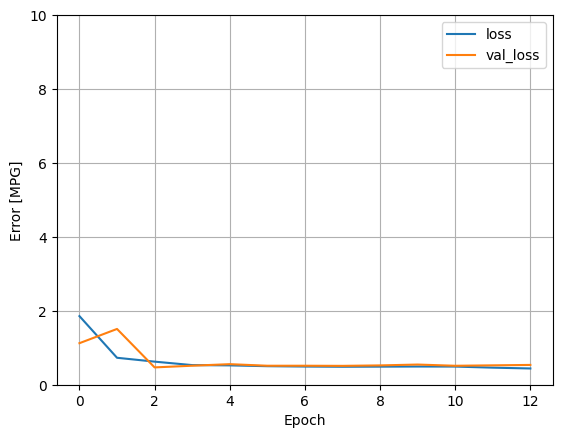

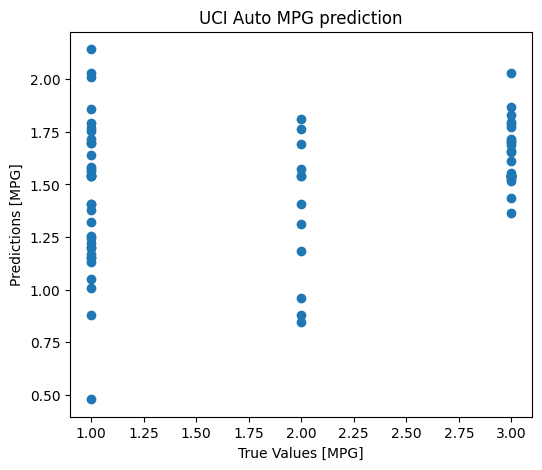

In [227]:
def runMLPNeuralNetRegressionTask():
    """
    Runs the Neural Net regression task
    """
    print(f"\nRun of the Neural Net regression task")
    print(f"X.shape: {X.shape}\ty.shape: {y.shape}")
    nn_model = MLPNeuralNet(
        X=X,
        y=y,
        network_topology=neural_network_topology,
        network_params=neural_network_params,
        task_type=TaskType.regression
    )
    nn_model.createNeuralNetModel()
    train_metrics = nn_model.trainRegressionModel()
    valid_r_squared = np.round(train_metrics["val_rSquared"][-1], 4)
    valid_mae = np.round(train_metrics["val_loss"][-1], 4)
    print(f"NN Training metrics:")
    print(f"Validated R^2: {valid_r_squared}")
    print(f"Validated MAE loss: {valid_mae}")
    print("\n\n")
    nn_model.visualizeModelLossAndAccuracy()
    nn_model.visualizePrediction()
    # nn_model.visualizePrediction(X_test=X_test, y_test=y_test, use_time_horizon=False)
    

runMLPNeuralNetRegressionTask()

In [223]:
list(PERFORMANCE_PLOT_FEATURE.values())[0]

1